In [53]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

warnings.filterwarnings("ignore")

## This notebook studies the relationship between frequency and moral relevance for conceptual categories

In [54]:
# Loading COHA time-series data
ts_df = pd.read_csv("./data/SWOW_prediction/eval/time_series/ts_df.csv")

ts_df = (
    ts_df.groupby(["words", "year", "property"])[["outputs_z", "count"]]
    .mean()
    .reset_index()
)
ts_df = ts_df.loc[ts_df["count"] >= 50]

In [55]:
# Loading category norm dataset
category_norms = pd.read_csv("./data/Referential version_Item level data.csv")
category_norms = category_norms.loc[category_norms["prod.freq"] > 1]
category_norms.groupby("category")["category.member"].count().to_dict()

{'academic subject': 41,
 'alcoholic drink': 30,
 'animal': 69,
 'art form': 16,
 'artistic movement': 9,
 'bathroom fixture': 19,
 'bird': 38,
 'bird of prey': 8,
 'boat': 16,
 'body of water': 15,
 'book genre': 22,
 'breed of dog': 36,
 'building': 34,
 'building material': 18,
 'camping equipment': 25,
 "carpenter's tool": 16,
 'chemical element': 35,
 'citrus fruit': 11,
 'clothing': 47,
 'colour': 24,
 'cosmetic': 23,
 'crime': 25,
 'dairy product': 11,
 'day of the week': 7,
 'disease': 24,
 'drug': 24,
 'emotion': 27,
 'fabric': 15,
 'family relationship': 42,
 'farm animal': 18,
 'fish': 26,
 'flower': 18,
 'four-legged animal': 38,
 'four-wheeled vehicle': 13,
 'fraction': 24,
 'fruit': 40,
 'fuel': 14,
 'furniture': 24,
 'gardening tool': 18,
 'gemstone': 12,
 'geometric shape': 17,
 'green vegetable': 19,
 'hair colour': 18,
 'hat': 17,
 'healthcare profession': 23,
 'herb': 16,
 'human dwelling': 18,
 'infectious disease': 14,
 'injury': 20,
 'insect': 27,
 'jewellery': 14

In [56]:
all_words = set(category_norms["category.member"])
ts_df = ts_df.loc[ts_df.words.isin(all_words)]
norms = category_norms.groupby("category")["category.member"].apply(list).to_dict()
print(len(norms))

117


In [57]:
category_df = pd.DataFrame()
for category in norms:
    words = norms[category]
    c_df = ts_df.loc[ts_df.words.isin(words)]
    c_df["category"] = category
    category_df = pd.concat((category_df, c_df), ignore_index=True)


rel_df = category_df.loc[category_df.property == "previous_link"]
pol_df = category_df.loc[category_df.property == "polarity"]

In [58]:
def get_growth_rate_word(category):
    c_df = rel_df.loc[rel_df.category == category]
    words = c_df.words.unique()
    if len(c_df) == 0:
        return []
    list_rows = []
    for word in words:
        w_df = c_df.loc[c_df.words == word]
        aggregate_moral_relevance = w_df.outputs_z.mean()
        is_moral = aggregate_moral_relevance > 0

        min_year = w_df.year.min()
        w_df["year"] = (w_df["year"] - min_year + 1) / 10
        model = smf.ols("outputs_z ~ year", data=w_df).fit()
        list_rows.append(
            {
                "category": category,
                "word": word,
                "r2": model.rsquared,
                "n": len(w_df),
                "fpvalue": model.f_pvalue,
                "intercept_coef": model.params.Intercept,
                "year_pvalue": model.pvalues.year,
                "year_coef": model.params.year,
                "is_moral": is_moral,
                "moral_relevance": aggregate_moral_relevance,
            },
        )
    result = pd.DataFrame(list_rows)
    return result


def get_growth_rate(category):
    c_df = rel_df.loc[rel_df.category == category]
    last_year_moral_relevance = c_df.loc[c_df.year == 2000].outputs_z.mean()
    if len(c_df) == 0:
        return []
    c_df = c_df.groupby("year")["outputs_z"].mean().reset_index()
    is_moral = True
    aggregate_moral_relevance = c_df.outputs_z.mean()
    if aggregate_moral_relevance < 0:
        is_moral = False
    min_year = c_df.year.min()
    c_df["year"] = (c_df["year"] - min_year + 1) / 10
    model = smf.ols("outputs_z ~ year", data=c_df).fit()
    return {
        "category": category,
        "r2": model.rsquared,
        "n": len(c_df),
        "fpvalue": model.f_pvalue,
        "intercept_coef": model.params.Intercept,
        "year_pvalue": model.pvalues.year,
        "year_coef": model.params.year,
        "is_moral": is_moral,
        "moral_relevance": aggregate_moral_relevance,
        "final_moral_relevance": last_year_moral_relevance,
    }

In [59]:
rel_df["count_log"] = np.log(rel_df["count"])
pol_df["count_log"] = np.log(pol_df["count"])

In [60]:
category = "supernatural being"
c_df = rel_df.loc[rel_df.category == category]

### As shown below, the frequency of category norms in COHA corpus is not a good predictor of its moral relevance.

In [61]:
rel_df

,words,year,property,outputs_z,count,category,count_log
1,art,1850,previous_link,-0.846708,4604.0,academic subject,8.434681
3,art,1860,previous_link,-0.858738,3648.0,academic subject,8.201934
5,art,1870,previous_link,-0.932422,3457.0,academic subject,8.148156
7,art,1880,previous_link,-0.951748,5444.0,academic subject,8.602269
9,art,1890,previous_link,-0.978088,5263.0,academic subject,8.568456
...,...,...,...,...,...,...,...
39287,skiing,1960,previous_link,-1.332685,97.0,winter sport,4.574711
39289,skiing,1970,previous_link,-1.338075,135.0,winter sport,4.905275
39291,skiing,1980,previous_link,-1.312948,159.0,winter sport,5.068904
39293,skiing,1990,previous_link,-1.232952,515.0,winter sport,6.244167


In [62]:
import os

os.getcwd()

'/project/6070308/armzn/moralization_temporal'

FileNotFoundError: [Errno 2] No such file or directory: './figs/category_frequency.png'

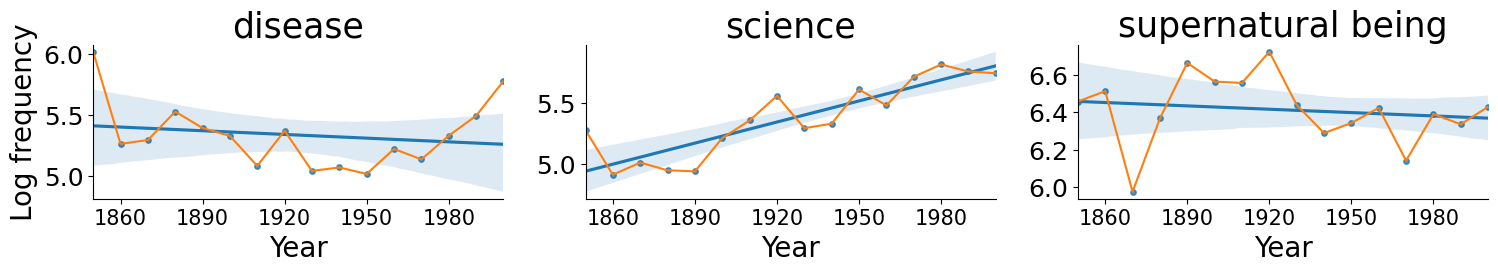

In [63]:
groups = ["disease", "science", "supernatural being"]
fig, axes = plt.subplots(1, 3, figsize=(18, 2), sharey=False)
for i, ax in enumerate(axes):
    c = groups[i]

    plot_df = rel_df.loc[rel_df.category == c]
    plot_df_2 = plot_df.groupby("year").count_log.mean().reset_index()

    sns.regplot(data=plot_df_2, x="year", y="count_log", ax=ax, scatter_kws={"s": 15})
    sns.lineplot(data=plot_df_2, x="year", y="count_log", ax=ax)
    ax.set_xlim(plot_df_2.year.min(), plot_df_2.year.max())
    ax.set_title(c, fontsize=25)

    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Log frequency", fontsize=20)
    ax.set_xlabel("Year", fontsize=20)

    ax.set_xticks(np.arange(1860, 2010, 30), np.arange(1860, 2010, 30), fontsize=15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
sns.despine()
plt.savefig("./figs/category_frequency.png", bbox_inches="tight", dpi=400)
plt.show()

In [ ]:
rel_df[["outputs_z", "count_log"]].drop_duplicates()

In [ ]:
## Moral relevance and frequency are only weakly correlated
pearsonr(
    rel_df[["outputs_z", "count_log"]].drop_duplicates().values.T[0],
    rel_df[["outputs_z", "count_log"]].drop_duplicates().values.T[1],
), len(rel_df[["outputs_z", "count_log", "words", "year"]].drop_duplicates())

In [ ]:
## Same result using all the COHA corpus
ts_df_rel = ts_df.loc[ts_df.property == "previous_link"]
pearsonr(
    ts_df_rel[["outputs_z", "count"]].drop_duplicates().values.T[0],
    ts_df_rel[["outputs_z", "count"]].drop_duplicates().values.T[1],
)